In [1]:
import numpy as np
import pandas as pd
import os
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

np.random.seed(97)

In [2]:
m = ["A", "C", "G", "T"]
def id2seq(ids):
    return "".join([m[i] for i in ids])

In [3]:
expression_percentile_thres = 90
ensemble_predictions_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/ensemble_predictions/"

In [4]:
os.listdir(ensemble_predictions_dir)

['filtered_ensemble_1_predictions.parquet',
 'dataset_seqs_eval_2.pkl',
 'all_ensemble_2_predictions.parquet',
 'all_ensemble_predictions.parquet',
 'dataset_seqs_eval.pkl',
 'all_ensemble_1_predictions.parquet',
 'coms_seqs_eval_2.pkl',
 'sequences_from_batch_1_expression_spectrum_eval_2.pkl',
 'coms_seqs_eval.pkl',
 'sequences_from_batch_1_expression_spectrum_eval.pkl',
 'den_seqs_eval_2.pkl',
 'den_seqs_eval.pkl',
 'sequences_generated_using_DE_motifs_eval.pkl',
 'sequences_generated_using_DE_motifs_eval_2.pkl']

In [5]:
dataset_sequences = pickle.load(open(os.path.join(ensemble_predictions_dir, "dataset_seqs_eval.pkl"), "rb"))
sequences_from_batch_1_expression_spectrum = pickle.load(open(os.path.join(ensemble_predictions_dir, "sequences_from_batch_1_expression_spectrum_eval.pkl"), "rb"))
sequences_generated_using_DE_motifs = pickle.load(open(os.path.join(ensemble_predictions_dir, "sequences_generated_using_DE_motifs_eval.pkl"), "rb"))
coms_sequences = pickle.load(open(os.path.join(ensemble_predictions_dir, "coms_seqs_eval.pkl"), "rb"))
dens_sequences = pickle.load(open(os.path.join(ensemble_predictions_dir, "den_seqs_eval.pkl"), "rb"))

In [6]:
# process COMs sequences
coms_df = {}
coms_df["design_method"] = []
coms_df["designed_for"] = []
coms_df["original_sequence"] = []
coms_df["sequence"] = []
coms_df["provenance"] = []
coms_df["coms_alpha"] = []
coms_df["diversity_loss_coef"] = []
coms_df["entropy_loss_coef"] = []
coms_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    coms_df[cell + "_ensemble_mean"] = []
    coms_df[cell + "_ensemble_std"] = []
    coms_df[cell + "_all_ensemble_preds"] = []
    coms_df[cell + "_design_model"] = []
    coms_df[cell + "_measured"] = []

ori_sequences = [id2seq(i) for i in coms_sequences["original_seq"]]

for cell in ["jurkat", "k562", "thp1"]:
    print(cell)
    sequences = [id2seq(i) for i in coms_sequences[f"{cell}_optimized_seq"]]
    
    corrected_cell_name = cell.upper()
    if cell == "jurkat":
        corrected_cell_name = "Jurkat"
    
    coms_df["designed_for"] += [corrected_cell_name for i in range(len(sequences))]
    coms_df["original_sequence"] += ori_sequences.copy()
    coms_df["sequence"] += ["".join(i) for i in sequences]
    coms_df["coms_alpha"] += list(coms_sequences["coms_loss_weight"])
    coms_df["provenance"] += [None for i in sequences]
    coms_df["diversity_loss_coef"] += [None for i in sequences]
    coms_df["entropy_loss_coef"] += [None for i in sequences]
    coms_df["base_entropy_loss_coef"] += [None for i in sequences]
    coms_df["design_method"] += ["COMs" for i in sequences]
    
    for cell2 in ["Jurkat", "K562", "THP1"]:
        coms_df[cell2 + "_ensemble_mean"] += list(coms_sequences[f"ensemble_{cell}_optimized_seq_{cell2.lower()}_pred"].mean(axis=0))
        coms_df[cell2 + "_ensemble_std"] += list(coms_sequences[f"ensemble_{cell}_optimized_seq_{cell2.lower()}_pred"].std(axis=0))
        coms_df[cell2 + "_all_ensemble_preds"] += [coms_sequences[f"ensemble_{cell}_optimized_seq_{cell2.lower()}_pred"]]
        coms_df[cell2 + "_design_model"] += list(coms_sequences[f"{cell}_opt_seq_{cell2.lower()}_pred"])
        coms_df[cell2 + "_measured"] += [None for i in sequences]

cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    coms_df[cell2 + "_all_ensemble_preds"] = np.hstack(coms_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = coms_df[cell2 + "_all_ensemble_preds"].copy()
    coms_df.pop(cell2 + "_all_ensemble_preds")

coms_df = pd.DataFrame(coms_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    coms_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(coms_df.shape[0])]
    
coms_df

jurkat
k562
thp1


design_method designed_for  \
0               COMs       Jurkat   
1               COMs       Jurkat   
2               COMs       Jurkat   
3               COMs       Jurkat   
4               COMs       Jurkat   
...              ...          ...   
306427          COMs         THP1   
306428          COMs         THP1   
306429          COMs         THP1   
306430          COMs         THP1   
306431          COMs         THP1   

                                        original_sequence  \
0       GTCTCTGGGCCGGAAGCCCCCTCTCCTCCCCCGCCGCAGCCCCCTC...   
1       ACCCGTGGGGAGGCGGTGAACTCCTCCGCAGGGGCCGATGCCCGGG...   
2       CGCTACCTCACTCACGGGCGAGAACTAAGCACCTACTGTGGACCCG...   
3       AACCTGGGACAACAGCAAAAAAAAAAAAAAAAAAAAAAAGGCCCCA...   
4       ACCCGGTGCCGGAGGCCGTGGGCGGCGACATGCAGCAGCTGAACCA...   
...                                                   ...   
306427  TACCTTATTCTTTAATGATTGCTTGTCACCATACGGATGAATCAGA...   
306428  CCAACACCCTACCTTTCTCTCTCTGGACCCACTTCCTCTTGCTGCC...   
306429  TGGTTTTTGCAGTCACACAGCTTTCCGAGACCCTCGTCCAGAGCAG...   
306430  GAAGGGCAGACAGCTGCCAGATACTTGCACCCCATTCCCTGGGGCC...   
306431  GAAGGGGTGGGGAGGGGAGAGAGTCCCTTTCAGTGCCCAAGCCTGT...   

                                                 sequence provenance  \
0       TCGAATAGTCCTATAAGCTCGTAAACTCCTACGCCACTATTCAGTA...       None   
1       TCAGGTGGGGGGGGGGCTTCGCGAGGCGCGCTGTCGTAAAATCGGC...       None   
2       CGTGATGTCATTCCGTGGGGAATCATTATGTATCAATAGGTATGCC...       None   
3       ATGGTGAGAATTCATTAGTTAGTAAATAATGAGGGCGGGGGCGTGA...       None   
4       AATGGCACGCGTAAACGGCATGTAAAGCCATAGAGCAGGTAAGGCG...       None   
...                                                   ...        ...   
306427  ATCCACGTTCAGGATTGATTCCACGTCACTTCCGTATTGAAAAGCA...       None   
306428  GCAGCTCACTTCCGTCATCCTTCTTCGGCTACTTCCGCAGAAGTCC...       None   
306429  AGGGCTGTTGAGCAAAGAGGATAGCCGGGTCTCTGGTAGGCAGTAT...       None   
306430  TCTGGTCTGGCAGCTGGTAGCAATTTGAGCGGCTTTCTCTTTGCCT...       None   
306431  CCCAAGGAAAAAAAAAAGCCAACTCCTGCGCAGGTCCTTGTCCTGT...       None   

        coms_alpha diversity_loss_coef entropy_loss_coef  \
0             0.00                None              None   
1             0.00                None              None   
2             0.00                None              None   
3             0.00                None              None   
4             0.00                None              None   
...            ...                 ...               ...   
306427        0.03                None              None   
306428        0.03                None              None   
306429        0.03                None              None   
306430        0.03                None              None   
306431        0.03                None              None   

       base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_ensemble_std  \
0                        None              1.530639  ...           0.286043   
1                        None              1.862692  ...           0.238900   
2                        None              1.876609  ...           0.309212   
3                        None              1.007456  ...           0.216337   
4                        None              1.246738  ...           0.246521   
...                       ...                   ...  ...                ...   
306427                   None             -0.006045  ...           0.192530   
306428                   None              0.429534  ...           0.209814   
306429                   None             -0.368069  ...           0.103942   
306430                   None             -0.456562  ...           0.117246   
306431                   None             -0.541174  ...           0.090040   

        K562_design_model K562_measured  THP1_ensemble_mean  \
0                0.804079          None            0.367058   
1                1.947420          None            0.408570   
2                1.120590          None            0.419875   
3                0.617886          None   

In [7]:
# process DENs sequences
dens_df = {}
dens_df["design_method"] = []
dens_df["designed_for"] = []
dens_df["original_sequence"] = []
dens_df["sequence"] = []
dens_df["coms_alpha"] = []
dens_df["provenance"] = []
dens_df["diversity_loss_coef"] = []
dens_df["entropy_loss_coef"] = []
dens_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    dens_df[cell + "_ensemble_mean"] = []
    dens_df[cell + "_ensemble_std"] = []
    dens_df[cell + "_all_ensemble_preds"] = []
    dens_df[cell + "_design_model"] = []
    dens_df[cell + "_measured"] = []
    
dens_df["designed_for"] += list(dens_sequences["designed_for"])
dens_df["design_method"] += ["DENs" for i in dens_sequences["sequence"]]
dens_df["original_sequence"] += [None for i in dens_sequences["sequence"]]

dens_df["sequence"] += [id2seq(i) for i in dens_sequences["sequence"]]

dens_df["provenance"] += [None for i in dens_sequences["sequence"]]
dens_df["coms_alpha"] += [float(i.split("_")[1]) for i in dens_sequences["design_model"]]
dens_df["diversity_loss_coef"] += list(dens_sequences["diversity_loss_coef"])
dens_df["entropy_loss_coef"] += list(dens_sequences["entropy_loss_coef"])
dens_df["base_entropy_loss_coef"] += list(dens_sequences["base_entropy_loss_coef"])

for cell2 in ["Jurkat", "K562", "THP1"]:
    dens_df[cell2 + "_ensemble_mean"] += list(dens_sequences[f"ensemble_sequence_{cell2.lower()}_pred"].mean(axis=0))
    dens_df[cell2 + "_ensemble_std"] += list(dens_sequences[f"ensemble_sequence_{cell2.lower()}_pred"].std(axis=0))
    dens_df[cell2 + "_all_ensemble_preds"] += [dens_sequences[f"ensemble_sequence_{cell2.lower()}_pred"]]
    dens_df[cell2 + "_design_model"] += list(dens_sequences[f"{cell2}"])
    dens_df[cell2 + "_measured"] += [None for i in dens_sequences["designed_for"]]
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    dens_df[cell2 + "_all_ensemble_preds"] = np.hstack(dens_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = dens_df[cell2 + "_all_ensemble_preds"].copy()
    dens_df.pop(cell2 + "_all_ensemble_preds")

dens_df = pd.DataFrame(dens_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    dens_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(dens_df.shape[0])]
    
dens_df

design_method designed_for original_sequence  \
0               DENs         THP1              None   
1               DENs         THP1              None   
2               DENs         THP1              None   
3               DENs         THP1              None   
4               DENs         THP1              None   
...              ...          ...               ...   
117498          DENs         K562              None   
117499          DENs         K562              None   
117500          DENs         K562              None   
117501          DENs         K562              None   
117502          DENs         K562              None   

                                                 sequence  coms_alpha  \
0       AACAAATTTTAATATACTACAGCTTCGGCCTTGCTTTTTTTTTTTT...      0.0003   
1       AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...      0.0003   
2       AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...      0.0003   
3       AACAAATTTTAATATACTACAGCTTCGGCCTTGCTTTTTTTTTTTT...      0.0003   
4       AACAAATTTTAATATACTACAGCTTCGGCCTTGCATTTTTTTTTTT...      0.0003   
...                                                   ...         ...   
117498  ACAAAAAACCAAAAAAGACCCCCAAAAAGCCCGCCCAACAAAAACG...      0.0000   
117499  AAACAACAAACACCAACACCAAAACCAAACCCCACCAAAAAAAAAA...      0.0000   
117500  AAAAAACAGCCCCAAAAACAAACACAAAAAAAAAACAACCCCGAAA...      0.0000   
117501  CACCCCCACACCCAAACCGAAACCACCACCCAAAAACCCCCCACAA...      0.0000   
117502  AAAAACCAGCCCCCCCCGGAAAAAAAAAAGAACCAGCAAAAACGAC...      0.0000   

       provenance  diversity_loss_coef  entropy_loss_coef  \
0            None                  1.0                1.0   
1            None                  1.0                1.0   
2            None                  1.0                1.0   
3            None                  1.0                1.0   
4            None                  1.0                1.0   
...           ...                  ...                ...   
117498       None                 10.0                1.0   
117499       None                 10.0                1.0   
117500       None                 10.0                1.0   
117501       None                 10.0                1.0   
117502       None                 10.0                1.0   

        base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_ensemble_std  \
0                          5.0              0.260749  ...           0.314870   
1                          5.0              0.392395  ...           0.327280   
2                          5.0              0.352313  ...           0.367410   
3                          5.0              0.419775  ...           0.330328   
4                          5.0              0.306372  ...           0.313557   
...                        ...                   ...  ...                ...   
117498                    10.0              1.079223  ...           0.285645   
117499                    10.0              1.040159  ...           0.297916   
117500                    10.0              1.185269  ...           0.304327   
117501                    10.0              1.042937  ...           0.291060   
117502                    10.0              1.049302  ...           0.284064   

        K562_design_model K562_measured  THP1_ensemble_mean  \
0                0.161597          None            0.711066   
1                0.177417          None            0.774647   
2                0.298792          None            0.806953   
3                0.211093          None            0.833610   
4                0.064643          None            0.709922   
...                   ...           ...                 ...   
117498           2.265131          None            0.712979   
117499           2.271510          None            0.732037   
117500           2.358301          None            0.826267   
117501           2.284508          None            0.681632   
117502           2.256965          None            0.742341   

        THP1_ensem

In [8]:
# process original dataset sequences
dataset_df = {}
dataset_df["design_method"] = []
dataset_df["designed_for"] = []
dataset_df["original_sequence"] = []
dataset_df["sequence"] = []
dataset_df["coms_alpha"] = []
dataset_df["provenance"] = []
dataset_df["diversity_loss_coef"] = []
dataset_df["entropy_loss_coef"] = []
dataset_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    dataset_df[cell + "_ensemble_mean"] = []
    dataset_df[cell + "_ensemble_std"] = []
    dataset_df[cell + "_all_ensemble_preds"] = []
    dataset_df[cell + "_design_model"] = []
    dataset_df[cell + "_measured"] = []

dataset_df["designed_for"] += [None for i in dataset_sequences["sequences"]]
dataset_df["design_method"] += ["Dataset" for i in dataset_sequences["sequences"]]
dataset_df["original_sequence"] += [None for i in dataset_sequences["sequences"]]

dataset_df["sequence"] += [id2seq(i) for i in dataset_sequences["sequences"]]

dataset_df["provenance"] += [None for i in dataset_sequences["sequences"]]
dataset_df["coms_alpha"] += [None for i in dataset_sequences["sequences"]]
dataset_df["diversity_loss_coef"] += [None for i in dataset_sequences["sequences"]]
dataset_df["entropy_loss_coef"] += [None for i in dataset_sequences["sequences"]]
dataset_df["base_entropy_loss_coef"] += [None for i in dataset_sequences["sequences"]]

for cell2 in ["Jurkat", "K562", "THP1"]:
    dataset_df[cell2 + "_ensemble_mean"] += list(dataset_sequences[f"ensemble_sequences_{cell2.lower()}_pred"].mean(axis=0))
    dataset_df[cell2 + "_ensemble_std"] += list(dataset_sequences[f"ensemble_sequences_{cell2.lower()}_pred"].std(axis=0))
    dataset_df[cell2 + "_all_ensemble_preds"] += [dataset_sequences[f"ensemble_sequences_{cell2.lower()}_pred"]]
    dataset_df[cell2 + "_design_model"] += [None for i in dataset_sequences["sequences"]]
    dataset_df[cell2 + "_measured"] += list(dataset_sequences[f"{cell2.lower()}_output"])
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    dataset_df[cell2 + "_all_ensemble_preds"] = np.hstack(dataset_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = dataset_df[cell2 + "_all_ensemble_preds"].copy()
    dataset_df.pop(cell2 + "_all_ensemble_preds")

dataset_df = pd.DataFrame(dataset_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    dataset_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(dataset_df.shape[0])]
    
dataset_df

design_method designed_for original_sequence  \
0           Dataset         None              None   
1           Dataset         None              None   
2           Dataset         None              None   
3           Dataset         None              None   
4           Dataset         None              None   
...             ...          ...               ...   
17099       Dataset         None              None   
17100       Dataset         None              None   
17101       Dataset         None              None   
17102       Dataset         None              None   
17103       Dataset         None              None   

                                                sequence coms_alpha  \
0      GTCTCTGGGCCGGAAGCCCCCTCTCCTCCCCCGCCGCAGCCCCCTC...       None   
1      ACCCGTGGGGAGGCGGTGAACTCCTCCGCAGGGGCCGATGCCCGGG...       None   
2      CGCTACCTCACTCACGGGCGAGAACTAAGCACCTACTGTGGACCCG...       None   
3      AACCTGGGACAACAGCAAAAAAAAAAAAAAAAAAAAAAAGGCCCCA...       None   
4      ACCCGGTGCCGGAGGCCGTGGGCGGCGACATGCAGCAGCTGAACCA...       None   
...                                                  ...        ...   
17099  ATGTGGGCCATTTACTGTCACTCATCTGTTGGTCATTTTACTTCCT...       None   
17100  GAATGTATGTACATTTGTTCCTGAGATACAGGTTGATGGACGGATG...       None   
17101  CTGGGGCTGGGCAGAGGGCAGGGAGGGGAAGGGTCCTGACCTCTGA...       None   
17102  CCTTCCAAATCCTCCTCCTAGAAGCCCTCCTTGGTTGGCCCTGCCT...       None   
17103  CCCCAAGATTAACCAGTTCTGTCCTGTCAGCAGGAGCAGGCAACTA...       None   

      provenance diversity_loss_coef entropy_loss_coef base_entropy_loss_coef  \
0           None                None              None                   None   
1           None                None              None                   None   
2           None                None              None                   None   
3           None                None              None                   None   
4           None                None              None                   None   
...          ...                 ...               ...                    ...   
17099       None                None              None                   None   
17100       None                None              None                   None   
17101       None                None              None                   None   
17102       None                None              None                   None   
17103       None                None              None                   None   

       Jurkat_ensemble_mean  ...  K562_ensemble_std K562_design_model  \
0                  2.658725  ...           0.327378              None   
1                  0.487816  ...           0.114694              None   
2                  0.798811  ...           0.119774              None   
3                  1.981933  ...           0.490993              None   
4                 -0.371285  ...           0.126482              None   
...                     ...  ...                ...               ...   
17099              0.097397  ...           0.075241              None   
17100             -0.564496  ...           0.172783              None   
17101             -0.642783  ...           0.101290              None   
17102             -0.343647  ...           0.081109              None   
17103              0.012765  ...           0.148214              None   

       K562_measured  THP1_ensemble_mean  THP1_ensemble_std THP1_design_model  \
0           2.849015            1.385821           0.230765              None   
1           0.141496           -0.045522           0.125966              None   
2           0.849015            0.055806           0.100324              None   
3           1.433977            0.992081           0.305253              None   
4          -0.943467           -0.239843           0.061097              None   
...              ...                 ...                ...               ...   
17099      -0.528565            0.116326           0.070366              None   
17100 

In [9]:
# process sequences from full spectrum of batch 1 expression
sequences_from_batch_1_expression_spectrum_df = {}
sequences_from_batch_1_expression_spectrum_df["design_method"] = []
sequences_from_batch_1_expression_spectrum_df["designed_for"] = []
sequences_from_batch_1_expression_spectrum_df["original_sequence"] = []
sequences_from_batch_1_expression_spectrum_df["sequence"] = []
sequences_from_batch_1_expression_spectrum_df["provenance"] = []
sequences_from_batch_1_expression_spectrum_df["coms_alpha"] = []
sequences_from_batch_1_expression_spectrum_df["diversity_loss_coef"] = []
sequences_from_batch_1_expression_spectrum_df["entropy_loss_coef"] = []
sequences_from_batch_1_expression_spectrum_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    sequences_from_batch_1_expression_spectrum_df[cell + "_ensemble_mean"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_ensemble_std"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_all_ensemble_preds"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_design_model"] = []
    sequences_from_batch_1_expression_spectrum_df[cell + "_measured"] = []

sequences_from_batch_1_expression_spectrum_df["designed_for"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["design_method"] += ["batchI_expression_spectrum" for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["original_sequence"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]

sequences_from_batch_1_expression_spectrum_df["sequence"] += [id2seq(i) for i in sequences_from_batch_1_expression_spectrum["sequence"]]

sequences_from_batch_1_expression_spectrum_df["provenance"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["coms_alpha"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["diversity_loss_coef"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["entropy_loss_coef"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
sequences_from_batch_1_expression_spectrum_df["base_entropy_loss_coef"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_ensemble_mean"] += list(sequences_from_batch_1_expression_spectrum[f"ensemble_sequence_{cell2.lower()}_pred"].mean(axis=0))
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_ensemble_std"] += list(sequences_from_batch_1_expression_spectrum[f"ensemble_sequence_{cell2.lower()}_pred"].std(axis=0))
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"] += [sequences_from_batch_1_expression_spectrum[f"ensemble_sequence_{cell2.lower()}_pred"]]
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_design_model"] += [None for i in sequences_from_batch_1_expression_spectrum["sequence"]]
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_measured"] += list(sequences_from_batch_1_expression_spectrum[f"{cell2}"])
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"] = np.hstack(sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"].copy()
    sequences_from_batch_1_expression_spectrum_df.pop(cell2 + "_all_ensemble_preds")

sequences_from_batch_1_expression_spectrum_df = pd.DataFrame(sequences_from_batch_1_expression_spectrum_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_from_batch_1_expression_spectrum_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(sequences_from_batch_1_expression_spectrum_df.shape[0])]
    
sequences_from_batch_1_expression_spectrum_df

design_method designed_for original_sequence  \
0    batchI_expression_spectrum         None              None   
1    batchI_expression_spectrum         None              None   
2    batchI_expression_spectrum         None              None   
3    batchI_expression_spectrum         None              None   
4    batchI_expression_spectrum         None              None   
..                          ...          ...               ...   
936  batchI_expression_spectrum         None              None   
937  batchI_expression_spectrum         None              None   
938  batchI_expression_spectrum         None              None   
939  batchI_expression_spectrum         None              None   
940  batchI_expression_spectrum         None              None   

                                              sequence provenance coms_alpha  \
0    CTGGGCTTGGAGGGCTCTAGGACCCAGCAACCTGCGCAGGGTGAAG...       None       None   
1    TCCTTTCATTTTGAGAAGAAGGAGGGAGGGGAGGGGGGACTTGGGG...       None       None   
2    CGAGCCCGGCTCGCCGAGGCCTCCCCACGCCCCCGCGGGGGTGGAG...       None       None   
3    AGGAGGAGAGGAGGCAGCGCCCGGCCAGGCTGGGAGCACCTACGGC...       None       None   
4    GGGCGCCTGAGGGTCCCGGCCACCCGAGAAGGGGGCTTCTTAATCG...       None       None   
..                                                 ...        ...        ...   
936  AGCTTTATAGGAATGCTGTTGCTTTAAATCCGAAATCCCGTGCCGG...       None       None   
937  AAACTCAGCGTGGGGTGGTGGGTTTCCCCGTCTTCTGGGAGACCCG...       None       None   
938  GCGCGGGGCCAATCAGCGTGCGCCGTTCCGAAAGTTGCCTTTTATG...       None       None   
939  GTGCGTCGGCTTCCGTACAACACGGATACTCTCTCTCTGACGCAAC...       None       None   
940  GCAAGTGGGCAGTGAGTGTGCCACGGACTGGCCTGGGCTGTGGCCT...       None       None   

    diversity_loss_coef entropy_loss_coef base_entropy_loss_coef  \
0                  None              None                   None   
1                  None              None                   None   
2                  None              None                   None   
3                  None              None                   None   
4                  None              None                   None   
..                  ...               ...                    ...   
936                None              None                   None   
937                None              None                   None   
938                None              None                   None   
939                None              None                   None   
940                None              None                   None   

     Jurkat_ensemble_mean  ...  K562_ensemble_std K562_design_model  \
0                0.732302  ...           0.338406              None   
1               -0.337329  ...           0.104476              None   
2               -0.338720  ...           0.154454              None   
3                0.220945  ...           0.137505              None   
4                0.280614  ...           0.369105              None   
..                    ...  ...                ...               ...   
936              3.533381  ...           0.608470              None   
937              0.632791  ...           0.974873              None   
938              3.740485  ...           0.919426              None   
939              3.946159  ...           1.129513              None   
940             -0.498041  ...           0.100725              None   

     K562_measured  THP1_ensemble_mean  THP1_ensemble_std THP1_design_model  \
0         0.821810            0.275853           0.168337              None   
1        -2.993798           -0.187078           0.090414              None   
2        -3.788144           -0.139790           0.066054              None   
3         1.487552            0.201762           0.076980              None   
4        -3.549167            0.054068           0.176084              None   
..             ...                 ...                ...               ...   
936       5.882017            2.616315   

In [10]:
# process sequences from full spectrum of batch 1 expression
sequences_generated_using_DE_motifs_df = {}
sequences_generated_using_DE_motifs_df["design_method"] = []
sequences_generated_using_DE_motifs_df["designed_for"] = []
sequences_generated_using_DE_motifs_df["original_sequence"] = []
sequences_generated_using_DE_motifs_df["sequence"] = []
sequences_generated_using_DE_motifs_df["provenance"] = []
sequences_generated_using_DE_motifs_df["coms_alpha"] = []
sequences_generated_using_DE_motifs_df["diversity_loss_coef"] = []
sequences_generated_using_DE_motifs_df["entropy_loss_coef"] = []
sequences_generated_using_DE_motifs_df["base_entropy_loss_coef"] = []

for cell in ["Jurkat", "K562", "THP1"]:    
    sequences_generated_using_DE_motifs_df[cell + "_ensemble_mean"] = []
    sequences_generated_using_DE_motifs_df[cell + "_ensemble_std"] = []
    sequences_generated_using_DE_motifs_df[cell + "_all_ensemble_preds"] = []
    sequences_generated_using_DE_motifs_df[cell + "_design_model"] = []
    sequences_generated_using_DE_motifs_df[cell + "_measured"] = []

sequences_generated_using_DE_motifs_df["designed_for"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["design_method"] += ["generated_using_DE_motifs" for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["original_sequence"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]

sequences_generated_using_DE_motifs_df["sequence"] += [id2seq(i) for i in sequences_generated_using_DE_motifs["sequence"]]

sequences_generated_using_DE_motifs_df["provenance"] += list(sequences_generated_using_DE_motifs["provenance"])
sequences_generated_using_DE_motifs_df["coms_alpha"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["diversity_loss_coef"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["entropy_loss_coef"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
sequences_generated_using_DE_motifs_df["base_entropy_loss_coef"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_generated_using_DE_motifs_df[cell2 + "_ensemble_mean"] += list(sequences_generated_using_DE_motifs[f"ensemble_sequence_{cell2.lower()}_pred"].mean(axis=0))
    sequences_generated_using_DE_motifs_df[cell2 + "_ensemble_std"] += list(sequences_generated_using_DE_motifs[f"ensemble_sequence_{cell2.lower()}_pred"].std(axis=0))
    sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"] += [sequences_generated_using_DE_motifs[f"ensemble_sequence_{cell2.lower()}_pred"]]
    sequences_generated_using_DE_motifs_df[cell2 + "_design_model"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
    sequences_generated_using_DE_motifs_df[cell2 + "_measured"] += [None for i in sequences_generated_using_DE_motifs["sequence"]]
    
cp = {}
for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"] = np.hstack(sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"]).T
    cp[cell2] = sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"].copy()
    sequences_generated_using_DE_motifs_df.pop(cell2 + "_all_ensemble_preds")

sequences_generated_using_DE_motifs_df = pd.DataFrame(sequences_generated_using_DE_motifs_df)

for cell2 in ["Jurkat", "K562", "THP1"]:
    sequences_generated_using_DE_motifs_df[cell2 + "_all_ensemble_preds"] = [cp[cell2][i, :] for i in range(sequences_generated_using_DE_motifs_df.shape[0])]
    
sequences_generated_using_DE_motifs_df

design_method designed_for original_sequence  \
0     generated_using_DE_motifs         None              None   
1     generated_using_DE_motifs         None              None   
2     generated_using_DE_motifs         None              None   
3     generated_using_DE_motifs         None              None   
4     generated_using_DE_motifs         None              None   
...                         ...          ...               ...   
1557  generated_using_DE_motifs         None              None   
1558  generated_using_DE_motifs         None              None   
1559  generated_using_DE_motifs         None              None   
1560  generated_using_DE_motifs         None              None   
1561  generated_using_DE_motifs         None              None   

                                               sequence  \
0     ACTGGCTGACTGCGCGTGCACGTGGGCCTGCGCTGAACGTGCACGA...   
1     CGGCGATCGCTTCCTCCTCGCTGCGAAAGGAGGGTCCCTCGCAGCA...   
2     AGGCGTTCCACGCGCTCACCTGAAGGTTCCCCATGCTCTCCTCTGC...   
3     TTCTGGGGGCACTACGATTCCCAGCTTCACGCGTGACTACAACTCC...   
4     GGGCACTGGGGGCGCCGGCGCCCGCTCCTCAGGCGCCGGCGCCTGT...   
...                                                 ...   
1557  GAAGATAAAGCCTTTTTTTTTGTCTCGGATGTCAGAAAGCCTCTCT...   
1558  GTGTGCTGCTTATTTCTTCCTACACCAGCTGTGTGTTACACTTCCT...   
1559  ACCCCCCTCCTCAATCTTCCTTGGCCCCCAACAAGCTATTCTTCTT...   
1560  CGTCCGGAAGCGAGTTTTCTTATTCTAGCTGCGCTCTTTTTTTCCT...   
1561  GGGTGGCACCAGTGAGGAAGTGACATGGGCTTTCTATTTCTTCCTG...   

                                             provenance coms_alpha  \
0     {'background_sequence': 'ACTGGCTGACTCGGCAGGGGG...       None   
1     {'background_sequence': 'CGGCGATCGCGCAGCCAATCC...       None   
2     {'background_sequence': 'AGGCGTTCCAGCCGGCCACTG...       None   
3     {'background_sequence': 'TTCTGGGGGCGTCCTGTCCGC...       None   
4     {'background_sequence': 'GGGCACTGGGCAGCCATTTTC...       None   
...                                                 ...        ...   
1557  {'background_sequence': 'GAAGATAAAGACACATGTACA...       None   
1558  {'background_sequence': 'GTGTGCTGCTCTGGACGAGGC...       None   
1559  {'background_sequence': 'ACCCCCCTCCCTCCCCGCCAG...       None   
1560  {'background_sequence': 'CGTCCGGAAGTCCGGGCGGAG...       None   
1561  {'background_sequence': 'GGGTGGCACCCACTCCAGAGA...       None   

     diversity_loss_coef entropy_loss_coef base_entropy_loss_coef  \
0                   None              None                   None   
1                   None              None                   None   
2                   None              None                   None   
3                   None              None                   None   
4                   None              None                   None   
...                  ...               ...                    ...   
1557                None              None                   None   
1558                None              None                   None   
1559                None              None                   None   
1560                None              None                   None   
1561                None              None                   None   

      Jurkat_ensemble_mean  ...  K562_ensemble_std K562_design_model  \
0                 2.293365  ...           0.174728              None   
1                 3.457778  ...           0.517160              None   
2                -0.364545  ...           0.114743              None   
3                 1.976278  ...           0.202019              None   
4                 0.664630  ...           0.378873              None   
...                    ...  ...                ...               ...   
1557              1.543655  ...           0.218436              None   
1558             -0.370872  ...           0.081593              None   
1559              3.347755  ...           0.410934              None   
1560              1.696500  ...           0.520814              None   
1561             -0.196534  ...           0.093410    

In [11]:
final_df = pd.concat([coms_df, 
                      dens_df, 
                      sequences_generated_using_DE_motifs_df,
                      dataset_df,
                      sequences_from_batch_1_expression_spectrum_df]).reset_index(drop=True)
final_df.to_parquet(os.path.join(ensemble_predictions_dir, "all_ensemble_1_predictions.parquet"))
final_df

design_method designed_for  \
0                             COMs       Jurkat   
1                             COMs       Jurkat   
2                             COMs       Jurkat   
3                             COMs       Jurkat   
4                             COMs       Jurkat   
...                            ...          ...   
443537  batchI_expression_spectrum         None   
443538  batchI_expression_spectrum         None   
443539  batchI_expression_spectrum         None   
443540  batchI_expression_spectrum         None   
443541  batchI_expression_spectrum         None   

                                        original_sequence  \
0       GTCTCTGGGCCGGAAGCCCCCTCTCCTCCCCCGCCGCAGCCCCCTC...   
1       ACCCGTGGGGAGGCGGTGAACTCCTCCGCAGGGGCCGATGCCCGGG...   
2       CGCTACCTCACTCACGGGCGAGAACTAAGCACCTACTGTGGACCCG...   
3       AACCTGGGACAACAGCAAAAAAAAAAAAAAAAAAAAAAAGGCCCCA...   
4       ACCCGGTGCCGGAGGCCGTGGGCGGCGACATGCAGCAGCTGAACCA...   
...                                                   ...   
443537                                               None   
443538                                               None   
443539                                               None   
443540                                               None   
443541                                               None   

                                                 sequence provenance  \
0       TCGAATAGTCCTATAAGCTCGTAAACTCCTACGCCACTATTCAGTA...       None   
1       TCAGGTGGGGGGGGGGCTTCGCGAGGCGCGCTGTCGTAAAATCGGC...       None   
2       CGTGATGTCATTCCGTGGGGAATCATTATGTATCAATAGGTATGCC...       None   
3       ATGGTGAGAATTCATTAGTTAGTAAATAATGAGGGCGGGGGCGTGA...       None   
4       AATGGCACGCGTAAACGGCATGTAAAGCCATAGAGCAGGTAAGGCG...       None   
...                                                   ...        ...   
443537  AGCTTTATAGGAATGCTGTTGCTTTAAATCCGAAATCCCGTGCCGG...       None   
443538  AAACTCAGCGTGGGGTGGTGGGTTTCCCCGTCTTCTGGGAGACCCG...       None   
443539  GCGCGGGGCCAATCAGCGTGCGCCGTTCCGAAAGTTGCCTTTTATG...       None   
443540  GTGCGTCGGCTTCCGTACAACACGGATACTCTCTCTCTGACGCAAC...       None   
443541  GCAAGTGGGCAGTGAGTGTGCCACGGACTGGCCTGGGCTGTGGCCT...       None   

       coms_alpha diversity_loss_coef entropy_loss_coef  \
0             0.0                None              None   
1             0.0                None              None   
2             0.0                None              None   
3             0.0                None              None   
4             0.0                None              None   
...           ...                 ...               ...   
443537       None                None              None   
443538       None                None              None   
443539       None                None              None   
443540       None                None              None   
443541       None                None              None   

       base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_ensemble_std  \
0                        None              1.530639  ...           0.286043   
1                        None              1.862692  ...           0.238900   
2                        None              1.876609  ...           0.309212   
3                        None              1.007456  ...           0.216337   
4                        None              1.246738  ...           0.246521   
...                       ...                   ...  ...                ...   
443537                   None              3.533381  ...           0.608470   
443538                   None              0.632791  ...           0.974873   
443539                   None              3.740485  ...           0.919426   
443540                   None              3.946159  ...           1.129513   
443541                   None             -0.498041  ...           0.100725   

       K562_design_model K562_measured  THP1_ensemble_mean  THP1_ensemble_std  \
0               0.804079          None            0.367058           0.

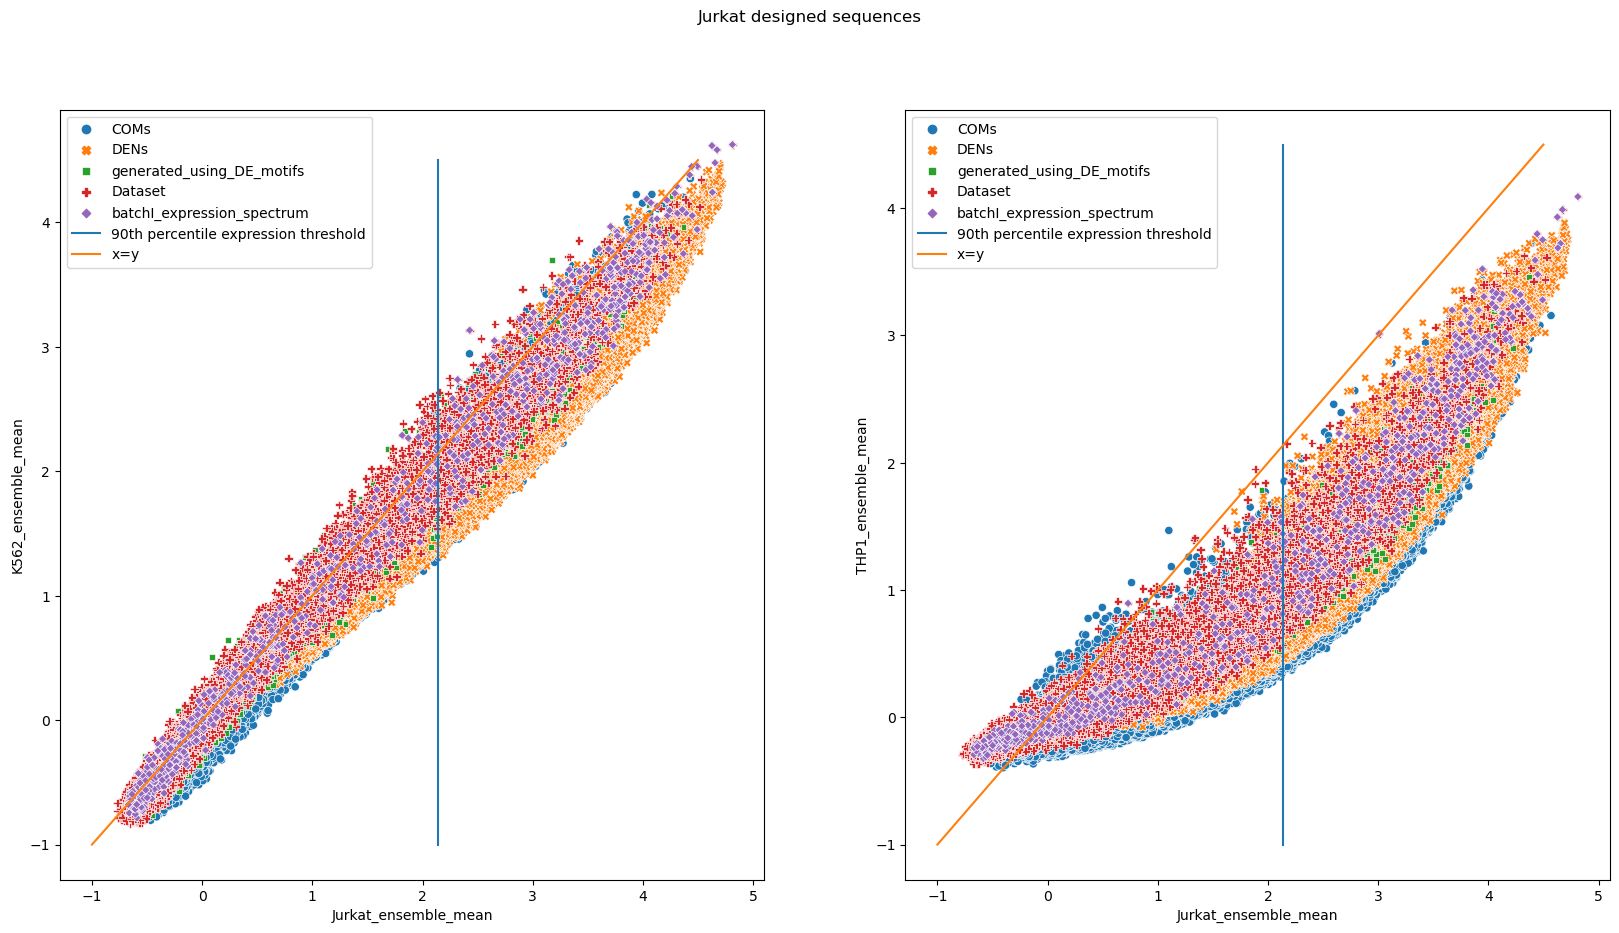

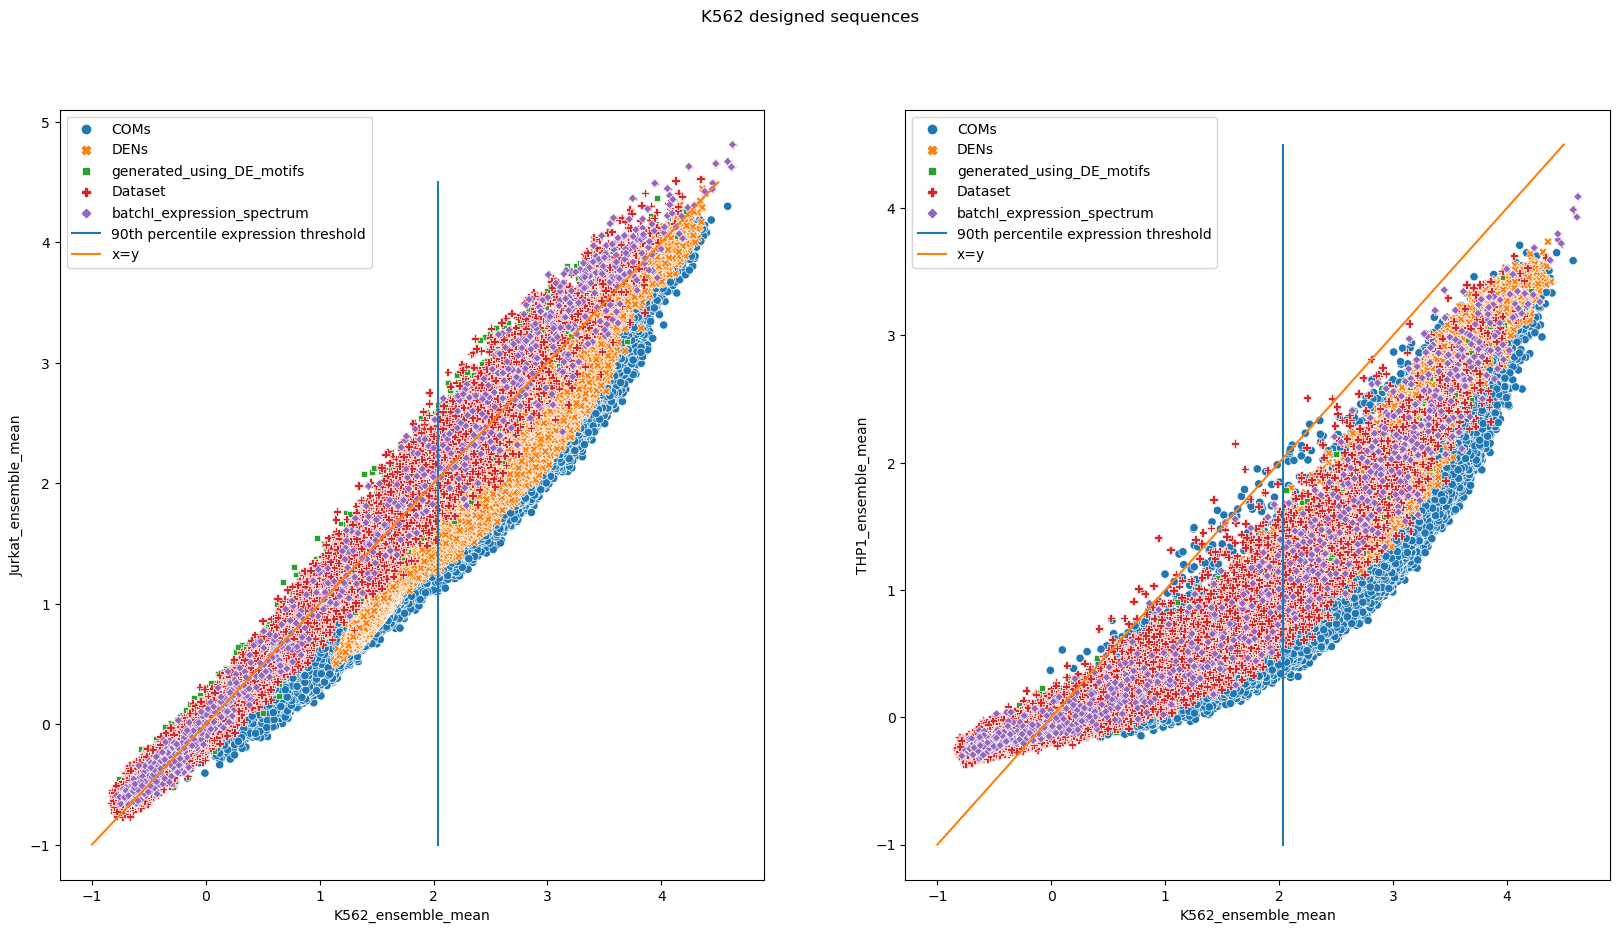

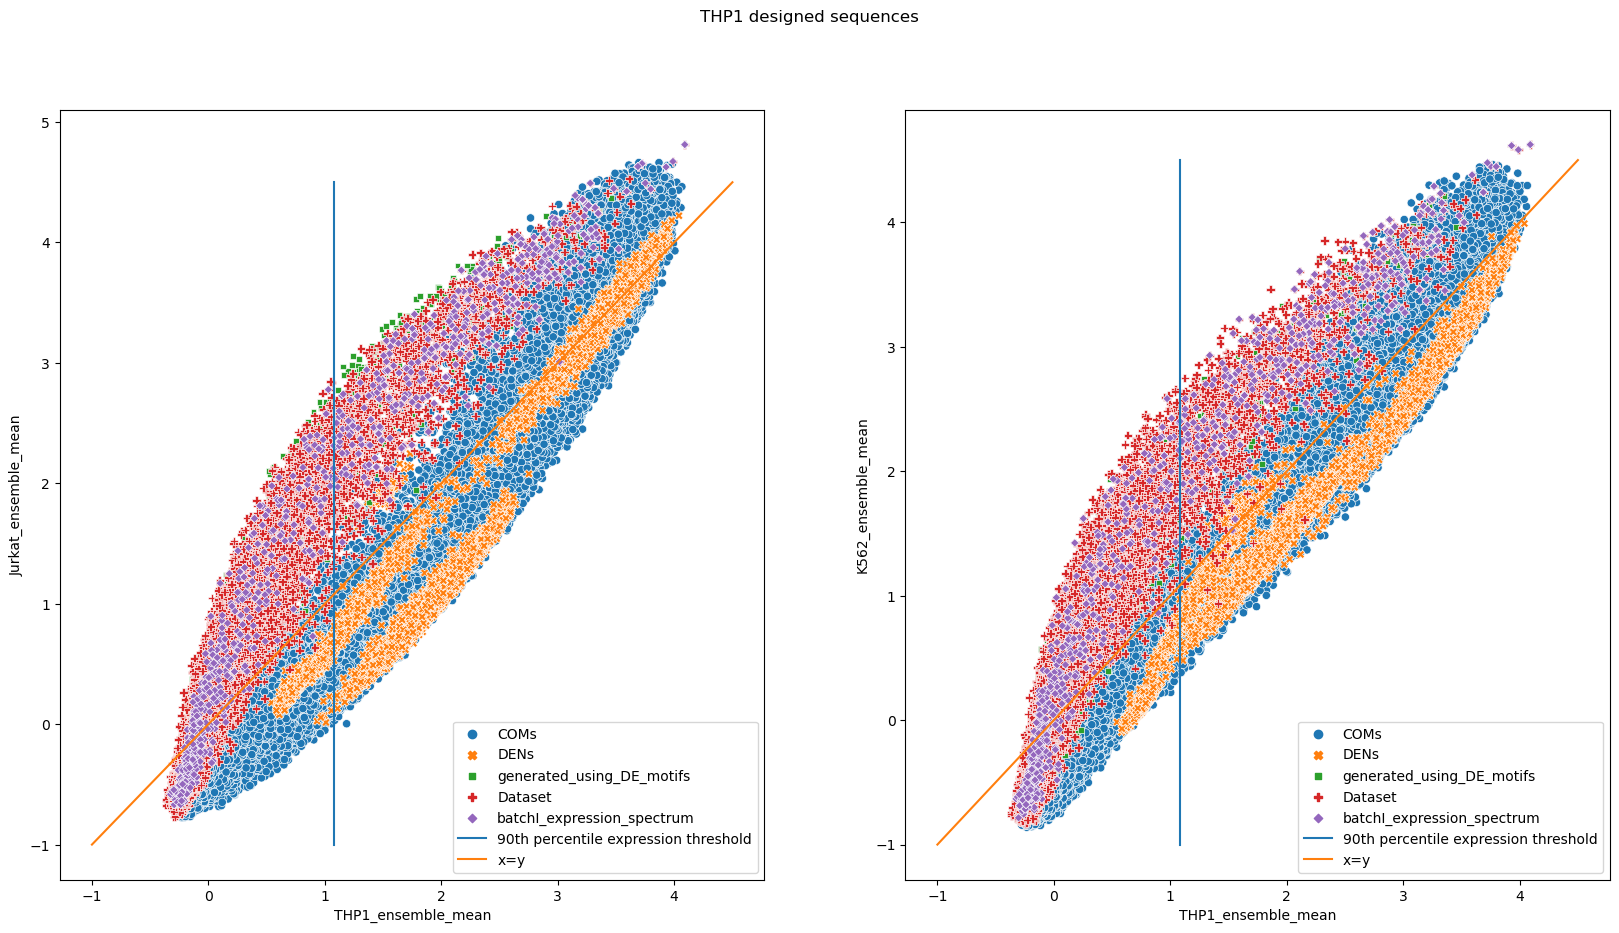

In [12]:
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    expression_percentile_thres_val = np.percentile(dataset_df[f"{cell1}_ensemble_mean"], expression_percentile_thres)
    
    subset_df = final_df[(final_df["designed_for"] == cell1) | (np.array(final_df["designed_for"]) == None)]
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    c = 0
    for j, cell2 in enumerate(["Jurkat", "K562", "THP1"]):
        if i == j:
            continue
        
        sns.scatterplot(data=subset_df, 
                        x=f"{cell1}_ensemble_mean", 
                        y=f"{cell2}_ensemble_mean", 
                        hue="design_method", style="design_method",
                        hue_order=["COMs", 
                                   "DENs", 
                                   "generated_using_DE_motifs", 
                                   "Dataset",
                                   "batchI_expression_spectrum"],
                        ax=ax[c])
        ax[c].plot(np.zeros(5) + expression_percentile_thres_val, np.linspace(-1, 4.5, 5), 
                   label=f"{expression_percentile_thres}th percentile expression threshold")
        ax[c].plot(np.linspace(-1, 4.5), np.linspace(-1, 4.5), label="x=y")
        ax[c].legend()
        c += 1
        
    fig.suptitle(f"{cell1} designed sequences")
    plt.show()

In [13]:
# filter sequences based on predicted expression and sort by differential expression
coms_df["filter_out"] = False
dens_df["filter_out"] = False
coms_df["diff_exp"] = 0.0
dens_df["diff_exp"] = 0.0
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    print(cell1)
    expression_percentile_thres_val = np.percentile(dataset_df[f"{cell1}_ensemble_mean"], expression_percentile_thres)
    print(f"Expression threshold = {expression_percentile_thres_val}")
    
    ori_COMs_num_seqs = (coms_df['designed_for'] == cell1).sum()
    ori_DENs_num_seqs = (dens_df['designed_for'] == cell1).sum()
    print(f"We had {ori_COMs_num_seqs} COMs designed sequences")
    print(f"We had {ori_DENs_num_seqs} DENs designed sequences")
    
    coms_df.loc[(coms_df["designed_for"] == cell1) & 
                (coms_df[f"{cell1}_ensemble_mean"] < expression_percentile_thres_val), "filter_out"] = True
    dens_df.loc[(dens_df["designed_for"] == cell1) & 
                (dens_df[f"{cell1}_ensemble_mean"] < expression_percentile_thres_val), "filter_out"] = True
    
    COMs_left_after_exp_thres = ((coms_df['designed_for'] == cell1) & ~coms_df['filter_out']).sum()
    DENs_left_after_exp_thres = ((dens_df['designed_for'] == cell1) & ~dens_df['filter_out']).sum()
    print(f"After filtering based on the expression threshold, we have {COMs_left_after_exp_thres} COMs designed sequences")
    print(f"After filtering based on the expression threshold, we have {DENs_left_after_exp_thres} DENs designed sequences")
    
    coms_df.loc[coms_df["designed_for"] == cell1, 
                "diff_exp"] = coms_df.loc[coms_df["designed_for"] == cell1, 
                                          f"{cell1}_ensemble_mean"]
    dens_df.loc[dens_df["designed_for"] == cell1, 
                "diff_exp"] = dens_df.loc[dens_df["designed_for"] == cell1, 
                                          f"{cell1}_ensemble_mean"]
    for j, cell2 in enumerate(["Jurkat", "K562", "THP1"]):
        if cell1 == cell2:
            continue
        coms_df.loc[(coms_df["designed_for"] == cell1) & 
                    (coms_df[f"{cell1}_ensemble_mean"] < coms_df[f"{cell2}_ensemble_mean"]), "filter_out"] = True
        dens_df.loc[(dens_df["designed_for"] == cell1) & 
                    (dens_df[f"{cell1}_ensemble_mean"] < dens_df[f"{cell2}_ensemble_mean"]), "filter_out"] = True
        
        coms_df.loc[coms_df["designed_for"] == cell1, 
                "diff_exp"] -= (coms_df.loc[coms_df["designed_for"] == cell1, 
                                          f"{cell2}_ensemble_mean"] * 0.5)
        dens_df.loc[dens_df["designed_for"] == cell1, 
                "diff_exp"] -= (dens_df.loc[dens_df["designed_for"] == cell1, 
                                          f"{cell2}_ensemble_mean"] * 0.5)
        
    COMs_left_after_DE_filt = ((coms_df['designed_for'] == cell1) & ~coms_df['filter_out']).sum()
    DENs_left_after_DE_filt = ((dens_df['designed_for'] == cell1) & ~dens_df['filter_out']).sum()
    print(f"After filtering based on the having non-zero DE, we have {COMs_left_after_DE_filt} COMs designed sequences")
    print(f"After filtering based on the having non-zero DE, we have {DENs_left_after_DE_filt} DENs designed sequences")

Jurkat
Expression threshold = 2.1367970228195197
We had 102144 COMs designed sequences
We had 69098 DENs designed sequences
After filtering based on the expression threshold, we have 46808 COMs designed sequences
After filtering based on the expression threshold, we have 56689 DENs designed sequences
After filtering based on the having non-zero DE, we have 46571 COMs designed sequences
After filtering based on the having non-zero DE, we have 56597 DENs designed sequences
K562
Expression threshold = 2.038790082931519
We had 102144 COMs designed sequences
We had 38668 DENs designed sequences
After filtering based on the expression threshold, we have 70162 COMs designed sequences
After filtering based on the expression threshold, we have 13050 DENs designed sequences
After filtering based on the having non-zero DE, we have 69128 COMs designed sequences
After filtering based on the having non-zero DE, we have 12454 DENs designed sequences
THP1
Expression threshold = 1.0806249260902407
We h

In [14]:
coms_df = coms_df[~coms_df["filter_out"]].sort_values(by="diff_exp").reset_index(drop=True)
dens_df = dens_df[~dens_df["filter_out"]].sort_values(by="diff_exp").reset_index(drop=True)
coms_df.to_parquet(os.path.join(ensemble_predictions_dir, "filtered_coms_sequences_ensemble_1.parquet"))
dens_df.to_parquet(os.path.join(ensemble_predictions_dir, "filtered_dens_sequences_ensemble_1.parquet"))

Jurkat


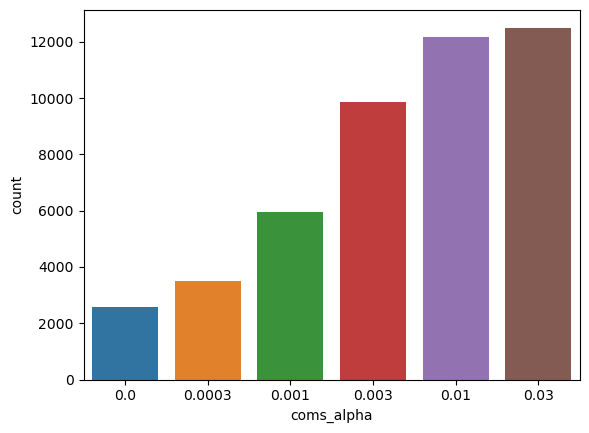

K562


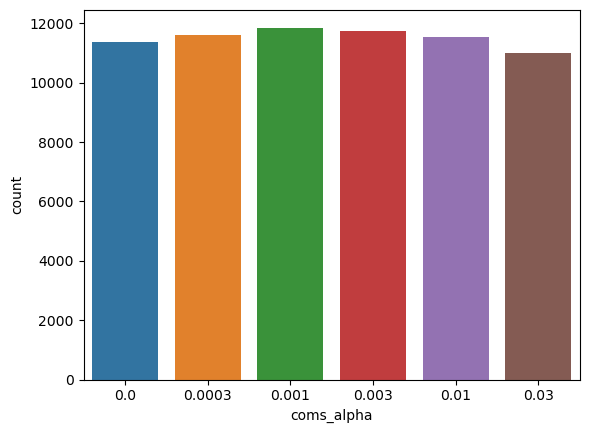

THP1


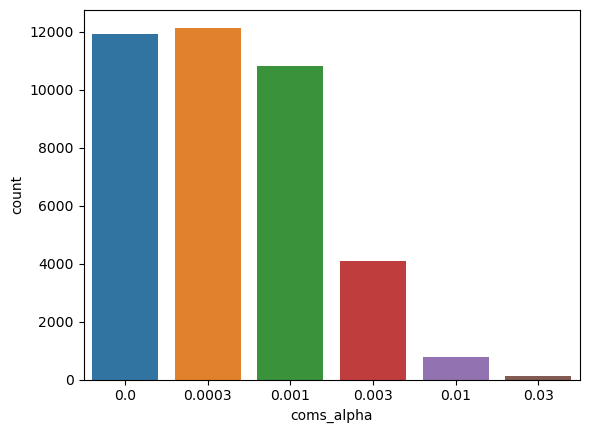

In [15]:
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    print(cell1)
    sns.countplot(data=coms_df[coms_df["designed_for"] == cell1], x="coms_alpha")
    plt.show()

In [16]:
final_df = pd.concat([coms_df, 
                      dens_df, 
                      sequences_generated_using_DE_motifs_df,
                      dataset_df,
                      sequences_from_batch_1_expression_spectrum_df]).reset_index(drop=True)
final_df.to_parquet(os.path.join(ensemble_predictions_dir, "filtered_ensemble_1_predictions.parquet"))
final_df

design_method designed_for  \
0                             COMs         THP1   
1                             COMs         THP1   
2                             COMs         THP1   
3                             COMs         THP1   
4                             COMs         THP1   
...                            ...          ...   
251596  batchI_expression_spectrum         None   
251597  batchI_expression_spectrum         None   
251598  batchI_expression_spectrum         None   
251599  batchI_expression_spectrum         None   
251600  batchI_expression_spectrum         None   

                                        original_sequence  \
0       TACGACAGCGGAGCCCCTGGGGAAGCCAAGATGCCGTCGAAGGGAA...   
1       GCTGCGCGGGGCAGGCGGGAGGTGATCGAGAGAGGCAGGGATGGGG...   
2       ACCGGGCCGCCCGCCGCCGGGCAGCTCCGCCCGCCTCTAGCGCCGG...   
3       GCAGGGCTTGGGGCTGGGTCTCCGGACAGAGGCCTGGCTTTTCTGT...   
4       CCGCGCCTTCGGGTGCGGCAGATTCTTCTGGGATTCGTCCAGAGCC...   
...                                                   ...   
251596                                               None   
251597                                               None   
251598                                               None   
251599                                               None   
251600                                               None   

                                                 sequence provenance  \
0       ATCGGGTGAGGAGGCACGAAAGGATACAGGAAGTGGCAGAGCCGAG...       None   
1       GTTGTGGGGTGCCAGCAGAAGGAGGCGGCGAAGTTCCGATCCGCAG...       None   
2       CCCCGCCGCCGCGCCGGCCGCCATTTCCTGGAGCGACGCTCTACGT...       None   
3       GCCGCTGCGGCCGCCGCCTCTCTCTCCGGCGGCCTCTCTCTTTTGT...       None   
4       GGCCCATCCCTGAAGGGCGCGACCATCTTGGCCGGCAGGAAGAAAG...       None   
...                                                   ...        ...   
251596  AGCTTTATAGGAATGCTGTTGCTTTAAATCCGAAATCCCGTGCCGG...       None   
251597  AAACTCAGCGTGGGGTGGTGGGTTTCCCCGTCTTCTGGGAGACCCG...       None   
251598  GCGCGGGGCCAATCAGCGTGCGCCGTTCCGAAAGTTGCCTTTTATG...       None   
251599  GTGCGTCGGCTTCCGTACAACACGGATACTCTCTCTCTGACGCAAC...       None   
251600  GCAAGTGGGCAGTGAGTGTGCCACGGACTGGCCTGGGCTGTGGCCT...       None   

        coms_alpha diversity_loss_coef entropy_loss_coef  \
0            0.003                None              None   
1            0.010                None              None   
2            0.001                None              None   
3            0.003                None              None   
4            0.001                None              None   
...            ...                 ...               ...   
251596         NaN                None              None   
251597         NaN                None              None   
251598         NaN                None              None   
251599         NaN                None              None   
251600         NaN                None              None   

       base_entropy_loss_coef  Jurkat_ensemble_mean  ...  K562_measured  \
0                        None              2.984944  ...           None   
1                        None              1.549221  ...           None   
2                        None              3.418495  ...           None   
3                        None              3.601715  ...           None   
4                        None              3.427151  ...           None   
...                       ...                   ...  ...            ...   
251596                   None              3.533381  ...       5.882017   
251597                   None              0.632791  ...       5.780755   
251598                   None              3.740485  ...        5.68394   
251599                   None              3.946159  ...       4.775424   
251600                   None             -0.498041  ...        6.17558   

        THP1_ensemble_mean THP1_ensemble_std  THP1_design_model  \
0                 2.990162          0.745384           2.358429   
1                 1.549747          0.292887          

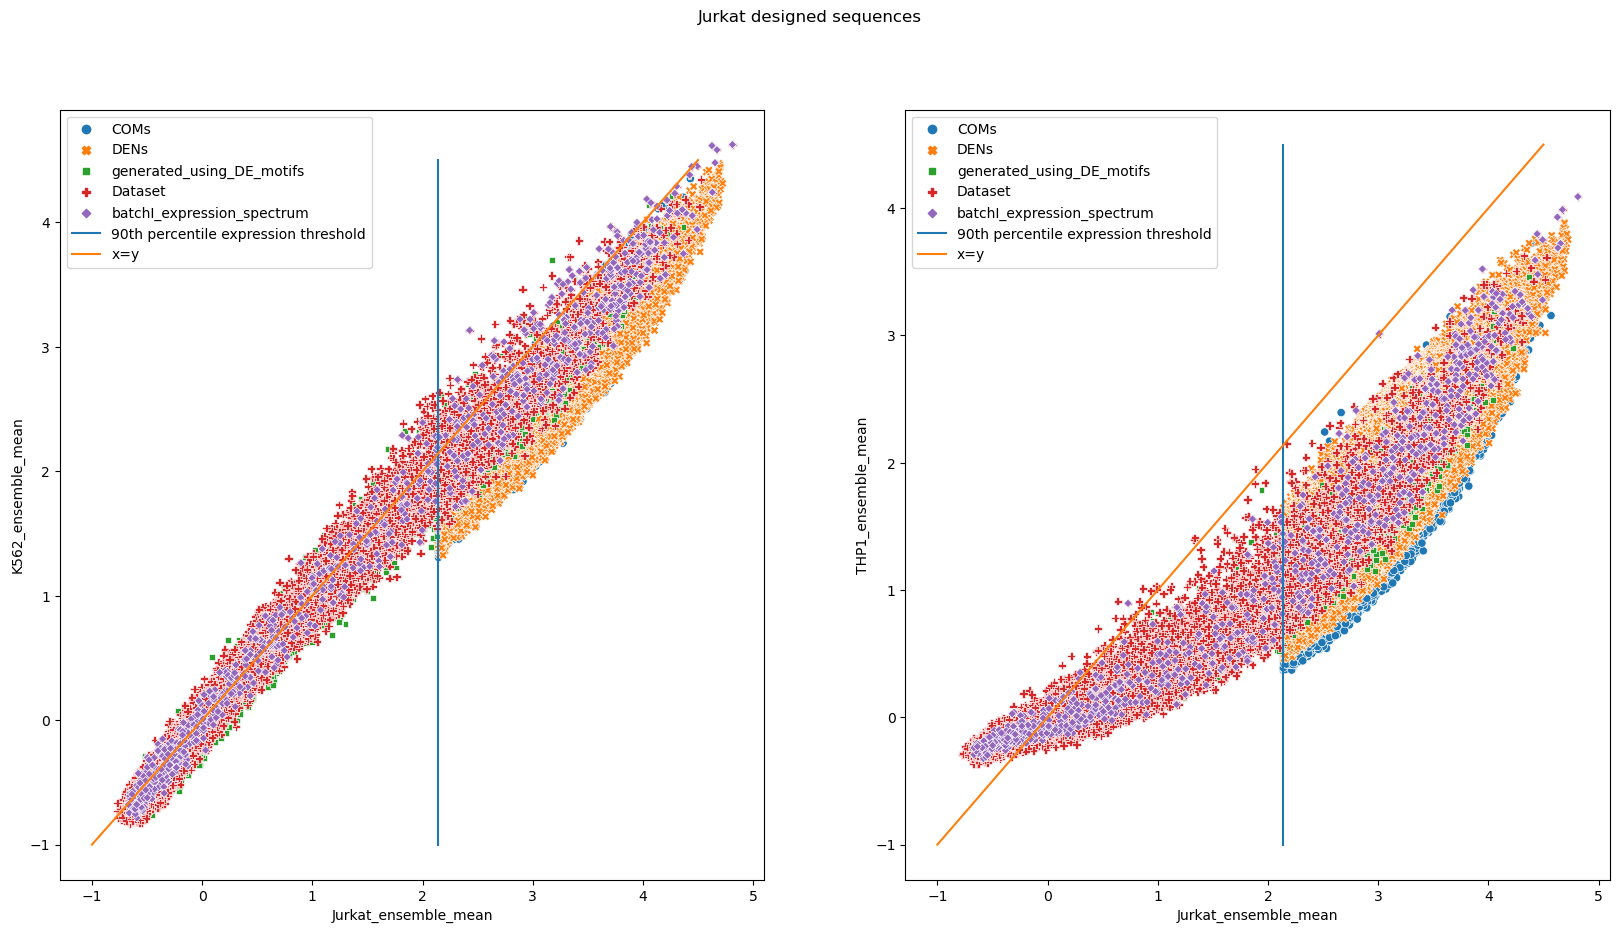

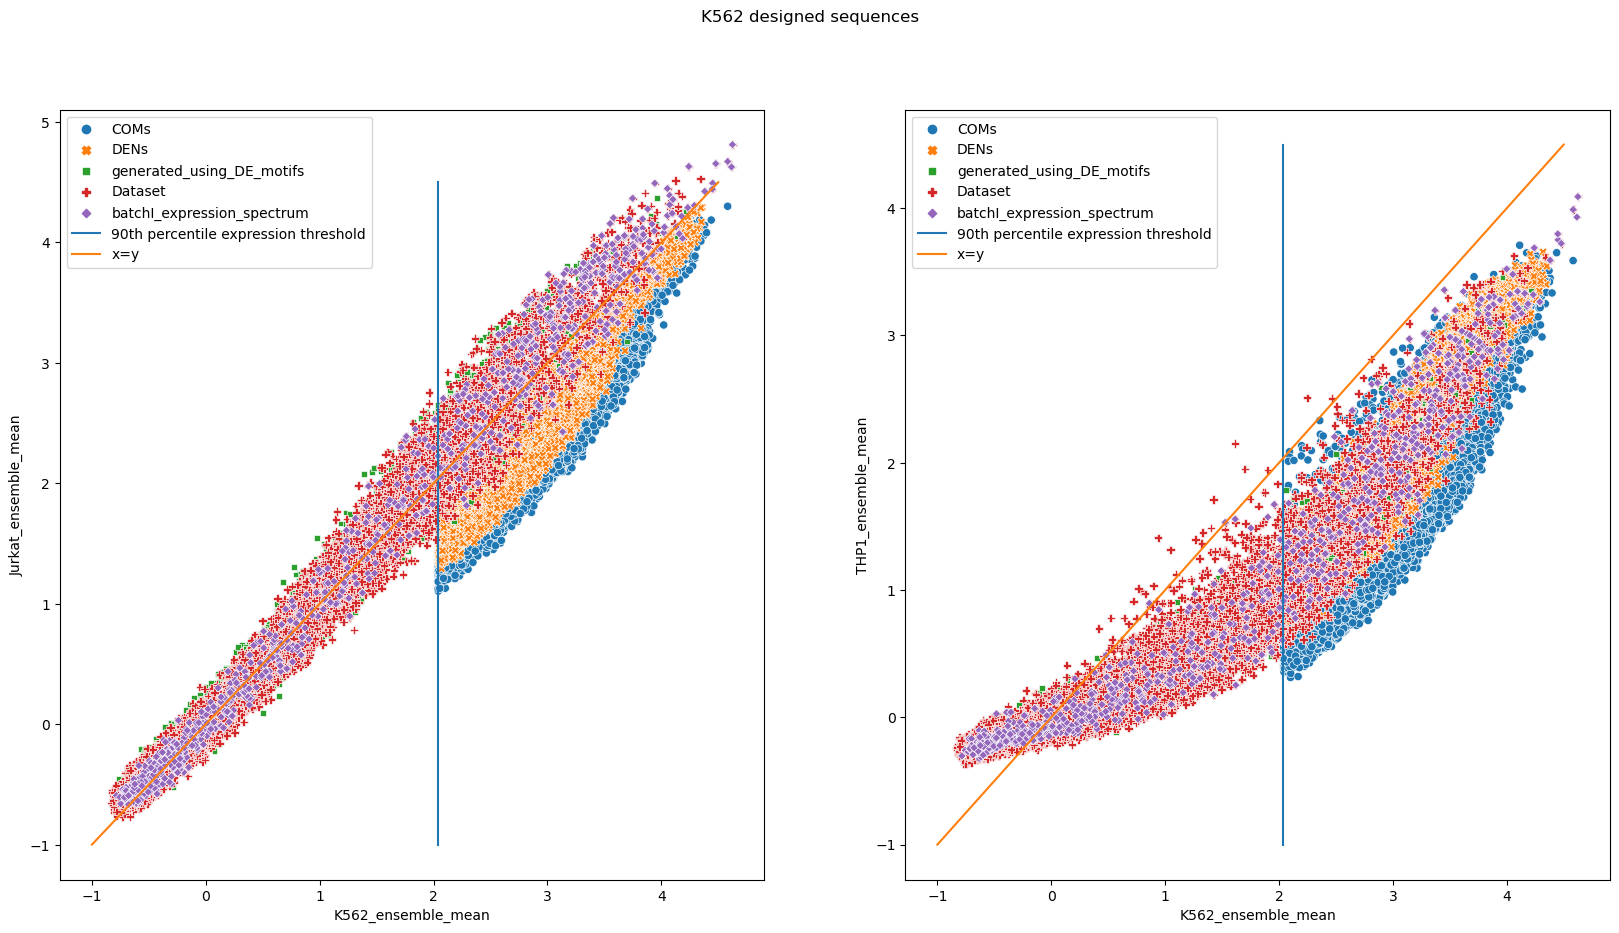

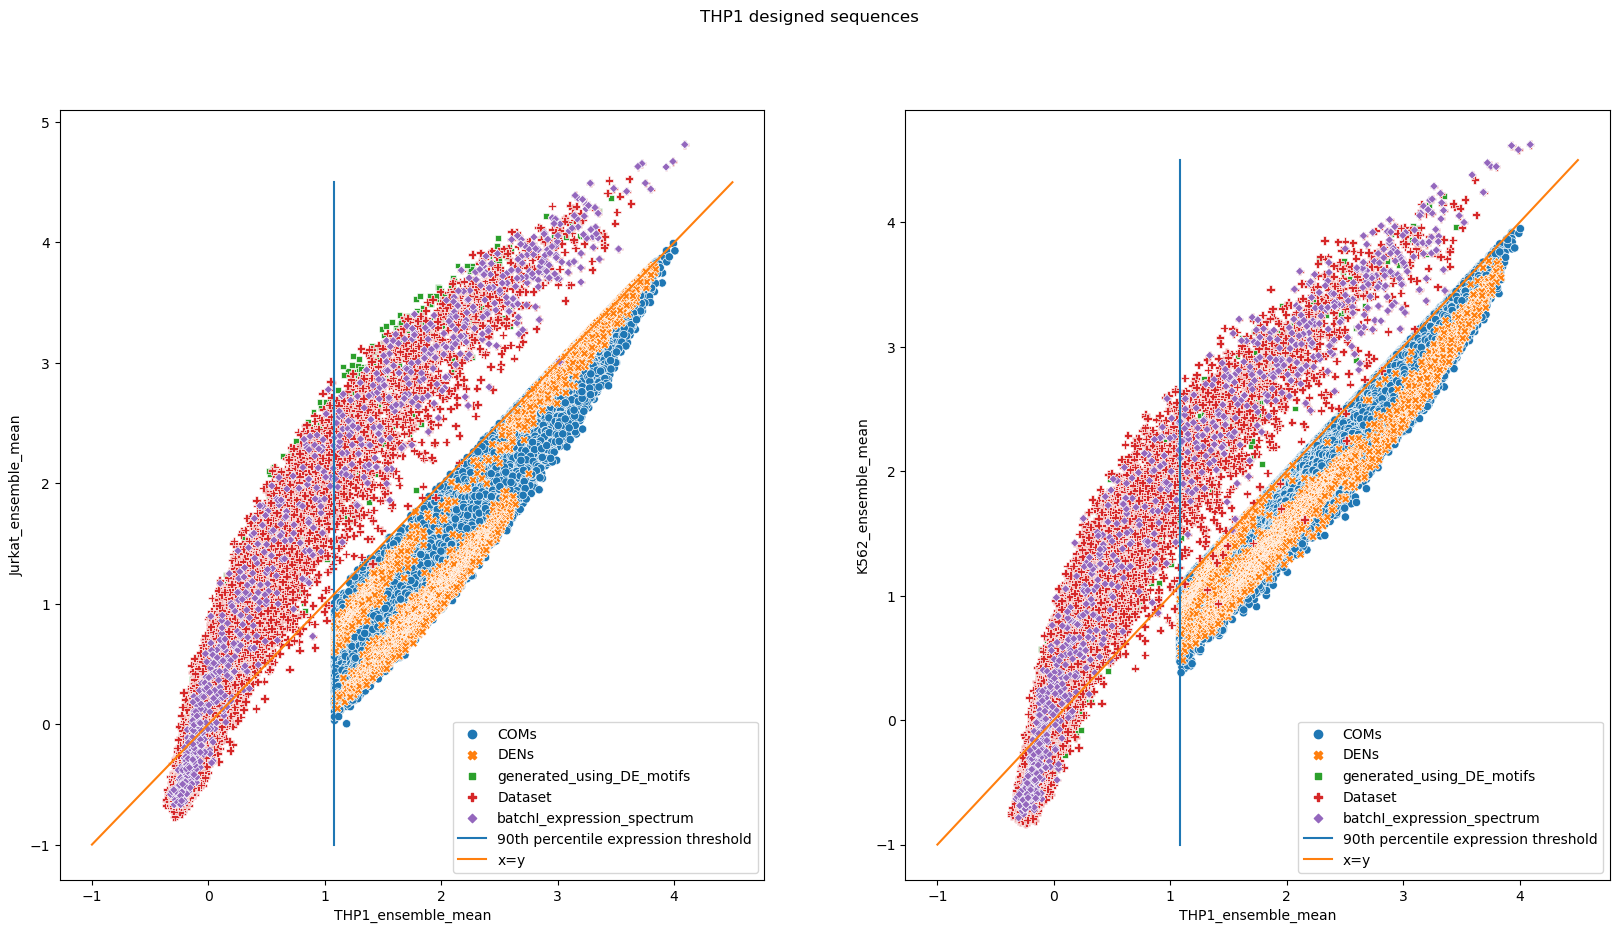

In [17]:
for i, cell1 in enumerate(["Jurkat", "K562", "THP1"]):
    expression_percentile_thres_val = np.percentile(dataset_df[f"{cell1}_ensemble_mean"], expression_percentile_thres)
    
    subset_df = final_df[(final_df["designed_for"] == cell1) | (np.array(final_df["designed_for"]) == None)]
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    c = 0
    for j, cell2 in enumerate(["Jurkat", "K562", "THP1"]):
        if i == j:
            continue
        
        sns.scatterplot(data=subset_df, 
                        x=f"{cell1}_ensemble_mean", 
                        y=f"{cell2}_ensemble_mean", 
                        hue="design_method", style="design_method",
                        hue_order=["COMs", 
                                   "DENs", 
                                   "generated_using_DE_motifs", 
                                   "Dataset",
                                   "batchI_expression_spectrum"],
                        ax=ax[c])
        ax[c].plot(np.zeros(5) + expression_percentile_thres_val, np.linspace(-1, 4.5, 5), 
                   label=f"{expression_percentile_thres}th percentile expression threshold")
        ax[c].plot(np.linspace(-1, 4.5), np.linspace(-1, 4.5), label="x=y")
        ax[c].legend()
        c += 1
        
    fig.suptitle(f"{cell1} designed sequences")
    plt.show()

In [19]:
coms_df[["designed_for", "sequence", "Jurkat_ensemble_mean", "K562_ensemble_mean", "THP1_ensemble_mean", "diff_exp"]].sort_values(by="diff_exp", ascending=False)

designed_for                                           sequence  \
155528       Jurkat  GTTGGTATCGCGCCTGCGCGGGCGTCTCGTGAGTGTACGGGGGGCA...   
155527       Jurkat  CTCTCGAATGGCGTTACGACGGCGGCGTCAGTACCATGGGCGCGAT...   
155526       Jurkat  CGCGTCAGAGAGTCATCACCGTGTCCCGTGCGGTTGCCGGGCTCGT...   
155525       Jurkat  GCGCATGCGTATAGGCGCTTAATTGGTGCGTGCGGGGCCGGGGGGG...   
155524       Jurkat  CTCTTCGAGTCGCAAGCCGGCTGGGGGGCGCGGAGCATTACTCGGG...   
...             ...                                                ...   
4              THP1  GGCCCATCCCTGAAGGGCGCGACCATCTTGGCCGGCAGGAAGAAAG...   
3              THP1  GCCGCTGCGGCCGCCGCCTCTCTCTCCGGCGGCCTCTCTCTTTTGT...   
2              THP1  CCCCGCCGCCGCGCCGGCCGCCATTTCCTGGAGCGACGCTCTACGT...   
1              THP1  GTTGTGGGGTGCCAGCAGAAGGAGGCGGCGAAGTTCCGATCCGCAG...   
0              THP1  ATCGGGTGAGGAGGCACGAAAGGATACAGGAAGTGGCAGAGCCGAG...   

        Jurkat_ensemble_mean  K562_ensemble_mean  THP1_ensemble_mean  diff_exp  
155528              3.656508            2.634850            1.685153  1.496507  
155527              3.397118            2.508586            1.368734  1.458458  
155526              3.395166            2.515244            1.375780  1.449655  
155525              3.370075            2.472044            1.374725  1.446691  
155524              3.255001            2.351089            1.271347  1.443783  
...                      ...                 ...                 ...       ...  
4                   3.427151            3.411284            3.427912  0.008694  
3                   3.601715            3.587420            3.603163  0.008595  
2                   3.418495            3.410989            3.422934  0.008192  
1                   1.549221            1.535590            1.549747  0.007342  
0                   2.984944            2.982480            2.990162  0.006450  

[155529 rows x 6 columns]

In [20]:
dens_df[["designed_for", "sequence", "Jurkat_ensemble_mean", "K562_ensemble_mean", "THP1_ensemble_mean", "diff_exp"]].sort_values(by="diff_exp", ascending=False)

designed_for                                           sequence  \
76464       Jurkat  TTTTCTATACCGTGGGGCGCGAAAGAGAGAATGGCGCGGCGCGCGC...   
76463       Jurkat  TTTTTTATACCCTGGGGCGCGTAAGAGAATGGCGCGCGCGCGCGCG...   
76462       Jurkat  TTTTCTATACCGTGGGGCGCGAAAGAGAGAGAGTCGCGCCGCGCGC...   
76461       Jurkat  TTTTCTATACCGTGGGGCGCGAAAGAGAGAATGGCGCGGCGCGCGC...   
76460       Jurkat  TTTTCTATACCGTGGGGCGCGAAAGAAGAGTGGCGCGCCGCGCGCG...   
...            ...                                                ...   
4             THP1  GGAAACCGGAAGCGGAAGAGGAAGAAGGAAGAACGCGGAAGATGGA...   
3             THP1  GCCGCGGCGGCGGCGGCGGCGGCGGGCGCCATCTTCGCCGTCTCGG...   
2             THP1  GCCGCCATCTTTCCGGCGCCGCGGCCCGCGGCGCGATCTTCGCCGC...   
1             THP1  CGCGCGGCGGCCGCGCGCCGCGGCGCCATCTTGCGCGGCGCCATCT...   
0             THP1  GGCGGCCGCGACGTCTTCGCGCGCGGGCCACGGGGCGCCATCTTTC...   

       Jurkat_ensemble_mean  K562_ensemble_mean  THP1_ensemble_mean  diff_exp  
76464              3.319525            2.313565            1.512157  1.406664  
76463              3.469763            2.520232            1.606314  1.406490  
76462              3.367637            2.417098            1.521374  1.398401  
76461              3.338988            2.344912            1.538556  1.397254  
76460              3.367251            2.388333            1.552666  1.396752  
...                     ...                 ...                 ...       ...  
4                  1.760838            1.668524            1.779792  0.065111  
3                  3.567562            3.501007            3.579812  0.045528  
2                  3.656207            3.634374            3.685589  0.040299  
1                  3.654472            3.642225            3.686301  0.037953  
0                  3.707699            3.677655            3.725636  0.032959  

[76465 rows x 6 columns]